<a href="https://colab.research.google.com/github/megan0422/DABPFinalProject/blob/main/Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import accuracy_score
from random import randrange
import warnings
import math
from sklearn import tree
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split #from imblearn import under_sampling, over_sampling
!pip install gurobipy
import gurobipy as gp
from gurobipy import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#Loading PA bridge dataset and filtering out bridges outside of Allegheny County
# NBI data
url = 'https://raw.githubusercontent.com/megan0422/DABPFinalProject/main/PA22%20-%20PA22.csv'
PA22 = pd.read_csv(url)
PA22_allegheny = PA22[PA22["COUNTY_CODE_003"] == 3]

In [33]:
#Variables most relevant to bridge condition prediction
relevant_variables_plus_alpha = ['PLACE_CODE_004', 'TOLL_020', 'MAINTENANCE_021',  'FUNCTIONAL_CLASS_026', 
                     'YEAR_BUILT_027', 'TRAFFIC_LANES_ON_028A' , 'ADT_029', 'DEGREES_SKEW_034',
                      'STRUCTURE_KIND_043A', 'STRUCTURE_TYPE_043B', 'MAIN_UNIT_SPANS_045', 
                      'MAX_SPAN_LEN_MT_048', 'STRUCTURE_LEN_MT_049', 'ROADWAY_WIDTH_MT_051', 
                      'CHANNEL_COND_061', 'DATE_OF_INSPECT_090', 'INSPECT_FREQ_MONTHS_091',
                      'HIGHWAY_SYSTEM_104', 'HIGHWAY_SYSTEM_104', 'DECK_STRUCTURE_TYPE_107', 
                      'SURFACE_TYPE_108A', 'MEMBRANE_TYPE_108B', 'DECK_PROTECTION_108C', 
                      'PERCENT_ADT_TRUCK_109', 'BRIDGE_CONDITION', 'DECK_AREA','TOTAL_IMP_COST_096','STRUCTURE_NUMBER_008']

#Creating a bridge dataset of variables for 'bridge-alone' classification models
Bridges_class = PA22_allegheny[PA22_allegheny.columns.intersection(relevant_variables_plus_alpha)]
Bridges_class.head(n=7)


,STRUCTURE_NUMBER_008,PLACE_CODE_004,TOLL_020,MAINTENANCE_021,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,STRUCTURE_KIND_043A,...,INSPECT_FREQ_MONTHS_091,TOTAL_IMP_COST_096,HIGHWAY_SYSTEM_104,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,PERCENT_ADT_TRUCK_109,BRIDGE_CONDITION,DECK_AREA
182,488,61000,3,1,14,1960,4,13887,99,4,...,24,6641.0,1,1,1,0,1,4.0,F,10462.97
183,491,24160,3,1,14,1960,2,16758,99,3,...,24,1372.0,1,1,1,0,1,10.0,F,1670.63
184,492,24160,3,1,14,1960,1,16107,99,3,...,24,1037.0,1,1,1,0,1,9.0,F,1596.00
185,495,69584,3,1,14,1925,4,32865,45,1,...,24,253.0,1,N,N,N,N,10.0,F,638.82
186,496,69584,3,1,14,1925,4,32865,5,1,...,24,0.0,1,N,N,N,N,10.0,F,410.04
187,497,69584,3,1,14,1912,4,21271,30,1,...,24,650.0,1,N,N,N,N,9.0,F,316.80
188,498,69584,3,1,14,1933,4,21271,30,3,...,24,228.0,1,1,6,0,0,9.0,F,316.59


In [34]:
Bridges_class.describe(include = 'all')
#Categorical values
#Bridges_class[['TOLL_020']].mean()

,STRUCTURE_NUMBER_008,PLACE_CODE_004,TOLL_020,MAINTENANCE_021,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,STRUCTURE_KIND_043A,...,INSPECT_FREQ_MONTHS_091,TOTAL_IMP_COST_096,HIGHWAY_SYSTEM_104,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,PERCENT_ADT_TRUCK_109,BRIDGE_CONDITION,DECK_AREA
count,1294,1294.00000,1294.000000,1294.000000,1294.000000,1294.000000,1294.00000,1294.000000,1294.000000,1294.000000,...,1294.000000,1107.000000,1294.000000,1294,1294,1294,1294,1293.000000,1294,1294.000000
unique,1294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,9,7,7,NaN,3,NaN
top,488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1,0,1,NaN,F,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,942,594,973,699,NaN,781,NaN
mean,NaN,49253.84544,2.948995,4.070325,14.506182,1965.890263,2.42813,12342.000773,26.336940,3.258887,...,25.569552,757.123758,0.481453,NaN,NaN,NaN,NaN,6.858469,NaN,1160.069776
std,NaN,20146.21782,0.255842,7.902959,3.580199,31.424179,1.11546,15761.580475,29.987121,1.632584,...,5.950377,4075.867578,0.499849,NaN,NaN,NaN,NaN,4.700891,NaN,2237.708729
min,NaN,724.00000,1.000000,1.000000,1.000000,1841.000000,1.00000,0.000000,0.000000,0.000000,...,23.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,27.740000
25%,NaN,32328.00000,3.000000,1.000000,11.000000,1946.250000,2.00000,2041.000000,0.000000,2.000000,...,24.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,5.000000,NaN,132.860000
50%,NaN,56384.00000,3.000000,1.000000,14.000000,1966.000000,2.00000,6583.000000,17.000000,3.000000,...,24.000000,117.000000,0.000000,NaN,NaN,NaN,NaN,6.000000,NaN,398.120000
75%,NaN,61000.00000,3.000000,2.000000,17.000000,1988.000000,3.00000,17445.000000,43.000000,4.000000,...,24.000000,516.000000,1.000000,NaN,NaN,NaN,NaN,8.000000,NaN,1252.555000


In [35]:
#Creates new column based on data dictionarys 

#TOLL_020 
Toll = {1:1, 2:1, 3:1, 4:1, 5:1}  
#MAINTENANCE_021 
#Note that more than one agency can share the responsibility of bridge maintenance, in these cases the agency 
#with the highest hieracrchy within that responsibility is listed (e.g. if both municipal and state share 
#responsibilities state will be listed). #According to the output in the chunk above, none of the bridges 
#in AC have a maintenace code above 31. For our purposes, highway and toll authority are grouped together 

Maintenance = {1: 'State', 2: 'County', 3: 'Municipal', 4: 'Municipal', 11: 'State', 12: 'Municipal', 
               21: 'State', 25: 'Municipal', 26: 'Private', 27: 'Railroad', 31: 'State', 
               32: 'Municipal'}

#FUNCTIONAL_CLASS_026
#Creating Urban category based on the FUNCTIONAL_CLASS data dictionary
Urban = {1:0,2:0,6:0,7:0,8:0,9:0,11:1,12:1,14:1,16:1,17:1,19:1}

#FUNCTIONAL_CLASS_026
Function = {1: 'Interstate Principal Arterial', 2: 'Other Principal Arterial', 6: 'Minor Arterial', 
            7: 'Major Collector', 8: 'Minor Collector', 9: 'Municipal', 11: 'Interstate Principal Arterial', 
            12: 'Other Principal Arterial Freeways', 14: 'Other Principal Arterial', 16: 'Minor Arterial',
            17: 'Collector', 19: 'Municipal'}

#STRUCTURE_KIND_043A
Structure_Kind = {1: 'Concrete', 2: 'Concrete continuous', 3: 'Steel', 4: 'Steel continuous', 5: 'Prestressed concrete', 
                  6: 'Prestressed concrete continuous', 7: 'Wood', 8: 'Masonary', 9: 'Aluminum', 0: 'Other'}

#STRUCTURE_TYPE_043B
Structure_Type = {1: 'Slab', 2: 'Stringer or Girder', 3: 'Girder and floorbeam', 4: 'Tee beam', 
                  5: 'Multiple box beams or girders', 6: 'Single box beam or girder', 7: 'Frame', 
                  8: 'Orthotropic', 9: 'Truss - Deck', 10: 'Truss - Thru', 11: 'Arch - Deck',
                  12: 'Arch - Thru', 13: 'Suspension', 14: 'Stayed Girder', 15: 'Movable - Lift',
                  16: 'Movable - Bascule', 17: 'Movable - Swing', 18: 'Tunnel', 19: 'Culvert',
                  20: 'Mixed types', 21: 'Segmental Box Girder', 22: 'Channel Beam', 0: 'Other'}

#DECK_STRUCTURE_TYPE_107
Deck = {'N': 0, '1': 1, '2': 1, '3': 1, '4': 1, '5':1, '6': 1, '7': 1, '8': 1, '9': 1}

Deck_Structure = {'N': 'No deck', '1': 'Concrete Cast-in-Place', '2': 'Concrete Precast Panels', 
                  '3': 'Open Grating', '4': 'Closed Grating', '5': 'Steel plate', '6': 'Corrugated Steel', 
                  '7': 'Aluminum', '8': 'Wood', '9': 'Other'}

#SURFACE_TYPE_108A
Surface_Type = {'N': 'No deck', '0': 'None', '1': 'Monolithic Concrete', '2': ' Integral Concrete', '3': 'Latex Concrete', 
                '4': 'Low Slump Concrete', '5': 'Epoxy Overlay', '6': 'Bituminous', '7': 'Wood', 
                '8': 'Gravel', '9': 'Other'}

#MEMBRANE_TYPE_108B
Membrane_Type = {'N': 'No deck','0': 'None', '1': 'Built-up', '2': 'Preformed Fabric', '3': 'Epoxy', '8': 'Unknown',
                 '9': 'Other'}

#DECK_PROTECTION_108C
Deck_Protect = {'N': 'No deck','0': 'None', '1': 'Epoxy Coated', '2': 'Galvanized', '3': 'Other Coated Reinforcing', 
                '4': 'Cathodic Protection', '6': 'Polymer Impregnated', '7': 'Internally Sealed', 
                '8': 'Unknown', '9': 'Other', }

In [36]:
#Using dictionaries to create new columns that are easier to interpret for the reader
new_variables = [ 'Age', 'Toll','Urban','Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 
                 'Deck_Structure', 'Surface_Type', 'Membrane_Type', 'Deck_Protect', 'Deck']

Bridges_class['Toll'] = Bridges_class['TOLL_020'].map(Toll)
Bridges_class['Maintenance'] = Bridges_class['MAINTENANCE_021'].map(Maintenance)
Bridges_class['Urban'] = Bridges_class['FUNCTIONAL_CLASS_026'].map(Urban)
Bridges_class['Function'] = Bridges_class['FUNCTIONAL_CLASS_026'].map(Function)
Bridges_class['Structure_Kind'] = Bridges_class['STRUCTURE_KIND_043A'].map(Structure_Kind)
Bridges_class['Structure_Type'] = Bridges_class['STRUCTURE_TYPE_043B'].map(Structure_Type)
Bridges_class['Deck_Structure'] = Bridges_class['DECK_STRUCTURE_TYPE_107'].map(Deck_Structure)
Bridges_class['Deck'] = Bridges_class['DECK_STRUCTURE_TYPE_107'].map(Deck)
Bridges_class['Surface_Type'] = Bridges_class['SURFACE_TYPE_108A'].map(Surface_Type)
Bridges_class['Membrane_Type'] = Bridges_class['MEMBRANE_TYPE_108B'].map(Membrane_Type)
Bridges_class['Deck_Protect'] = Bridges_class['DECK_PROTECTION_108C'].map(Deck_Protect)
Bridges_class['Age'] = 2022 - Bridges_class['YEAR_BUILT_027']

Bridges_class[Bridges_class.columns.intersection(new_variables)].head()

,Toll,Maintenance,Urban,Function,Structure_Kind,Structure_Type,Deck_Structure,Deck,Surface_Type,Membrane_Type,Deck_Protect,Age
182,1,State,1,Other Principal Arterial,Steel continuous,Truss - Deck,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
183,1,State,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
184,1,State,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
185,1,State,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97
186,1,State,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97


In [37]:
#convert DATE_OF_INSPECT_090_test to datetime object
Bridges_class['DATE_OF_INSPECT_090']=pd.to_datetime(Bridges_class['DATE_OF_INSPECT_090'], format='%m%y')                                                      

In [38]:
#Change new categorical variable into category data type 
category_vars = ['Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 'Deck_Structure', 'Surface_Type', 
                'Membrane_Type', 'Deck_Protect'] 
#Values need to be 'category' dtype to make dummy variables

for var in category_vars:
     Bridges_class[var] = Bridges_class[var].astype('category')
Bridges_class[Bridges_class.columns.intersection(category_vars)].head()

,Maintenance,Function,Structure_Kind,Structure_Type,Deck_Structure,Surface_Type,Membrane_Type,Deck_Protect
182,State,Other Principal Arterial,Steel continuous,Truss - Deck,Concrete Cast-in-Place,Monolithic Concrete,None,Epoxy Coated
183,State,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,Monolithic Concrete,None,Epoxy Coated
184,State,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,Monolithic Concrete,None,Epoxy Coated
185,State,Other Principal Arterial,Concrete,Arch - Deck,No deck,No deck,No deck,No deck
186,State,Other Principal Arterial,Concrete,Arch - Deck,No deck,No deck,No deck,No deck


In [39]:
#List of all variables that will be considered for classification. See report.  
all_variables = new_variables + ['PLACE_CODE_004','TRAFFIC_LANES_ON_028A' , 'ADT_029', 'DEGREES_SKEW_034', 
                                 'MAX_SPAN_LEN_MT_048', 'STRUCTURE_LEN_MT_049', 'ROADWAY_WIDTH_MT_051', 
                                 'MAIN_UNIT_SPANS_045','INSPECT_FREQ_MONTHS_091','HIGHWAY_SYSTEM_104', 
                                 'PERCENT_ADT_TRUCK_109', 'BRIDGE_CONDITION', 'DECK_AREA','TOTAL_IMP_COST_096','STRUCTURE_NUMBER_008'] 

                                    
Bridges_class_v2 = Bridges_class[Bridges_class.columns.intersection(all_variables)]
Bridges_class_v2.head()
#MAX_SPAN_LEN_MT_048, STRUCTURE_LEN_MT_049, ROADWAY_WIDTH_MT_051 and others need to be transformed because last digit is a tenth
# For example Length of Maximum Span 35.5 meters 00355

,STRUCTURE_NUMBER_008,PLACE_CODE_004,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,...,Urban,Function,Structure_Kind,Structure_Type,Deck_Structure,Deck,Surface_Type,Membrane_Type,Deck_Protect,Age
182,488,61000,4,13887,99,4,121.9,641.9,15.2,24,...,1,Other Principal Arterial,Steel continuous,Truss - Deck,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
183,491,24160,2,16758,99,11,26.8,235.3,6.0,24,...,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
184,492,24160,1,16107,99,11,25.9,212.8,6.4,24,...,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
185,495,69584,4,32865,45,1,21.0,33.8,15.3,24,...,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97
186,496,69584,4,32865,5,1,20.4,20.4,17.5,24,...,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97


In [40]:
#All continuous variables have to be normalized: ADT_029, DEGREES_SKEW_034,MAIN_UNIT_SPANS_045, MAX_SPAN_LEN_MT_048,
#ROADWAY_WIDTH_MT_051, etc
continous_var = ['Age','ADT_029', 'DEGREES_SKEW_034', 'TRAFFIC_LANES_ON_028A', 'MAIN_UNIT_SPANS_045', 
                 'MAX_SPAN_LEN_MT_048', 'ROADWAY_WIDTH_MT_051', 'STRUCTURE_LEN_MT_049', 'DECK_AREA', 
                 'INSPECT_FREQ_MONTHS_091', 'PERCENT_ADT_TRUCK_109']

def normalize(df, features):
    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df

Bridges_class_norm = normalize(Bridges_class_v2, continous_var)


In [41]:
dummy_vars = ['Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 'Deck_Structure', 
              'Surface_Type', 'Membrane_Type', 'Deck_Protect']
drop_columns = ['PLACE_CODE_004']
def prep_bridge_class_norm(df, dummy_vars, drop_columns):
    df = df.drop(columns = drop_columns) 
    result = {'P':0, 'F':1, 'G':1}  #Poor bridges are 0, fair and good are 1, found models are more accurate 
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].astype('string')
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].map(result)
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].astype('uint8')
    df['PERCENT_ADT_TRUCK_109'] = df['PERCENT_ADT_TRUCK_109'].fillna(0) #missing percent average dailt traffic truck is 0
    all_variables = list(df.columns)
    other_vars = [x for x in all_variables if x not in dummy_vars]
    df2 = pd.get_dummies(df[dummy_vars])
    df3 = pd.concat([df[other_vars], df2], axis=1) #concatenates continous variables with dummy variables
    return df3

In [42]:
df = prep_bridge_class_norm(Bridges_class_norm, dummy_vars, drop_columns)

In [43]:
df.drop(columns = ['Deck_Structure_No deck'])

,STRUCTURE_NUMBER_008,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,TOTAL_IMP_COST_096,...,Membrane_Type_Other,Membrane_Type_Preformed Fabric,Membrane_Type_Unknown,Deck_Protect_Epoxy Coated,Deck_Protect_Galvanized,Deck_Protect_No deck,Deck_Protect_None,Deck_Protect_Other,Deck_Protect_Other Coated Reinforcing,Deck_Protect_Unknown
182,488,0.428571,0.132004,1.000000,0.085714,0.503804,0.461092,0.324094,0.04,6641.0,...,0,0,0,1,0,0,0,0,0,0
183,491,0.142857,0.159295,1.000000,0.285714,0.101860,0.166219,0.127932,0.04,1372.0,...,0,0,0,1,0,0,0,0,0,0
184,492,0.000000,0.153107,1.000000,0.285714,0.098056,0.149902,0.136461,0.04,1037.0,...,0,0,0,1,0,0,0,0,0,0
185,495,0.428571,0.312402,0.454545,0.000000,0.077346,0.020088,0.326226,0.04,253.0,...,0,0,0,0,0,1,0,0,0,0
186,496,0.428571,0.312402,0.050505,0.000000,0.074810,0.010371,0.373134,0.04,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23023,67830,0.142857,0.000010,0.000000,0.057143,0.330093,0.147654,0.260128,0.04,NaN,...,0,0,0,1,0,0,0,0,0,0
23036,67876,0.142857,0.041787,0.353535,0.028571,0.128910,0.038436,0.208955,0.04,NaN,...,0,0,0,1,0,0,0,0,0,0
23078,68228,0.142857,0.507685,0.000000,1.000000,0.058326,0.425049,0.200426,0.04,0.0,...,0,0,0,1,0,0,0,0,0,0
23127,68593,0.428571,0.281195,0.666667,0.028571,0.155959,0.054391,0.390192,0.04,NaN,...,0,0,0,1,0,0,0,0,0,0


In [44]:
df2=df[df['Maintenance_County']==1]

In [45]:
df2_cost_NA=df2[df2['TOTAL_IMP_COST_096'].isna()]

In [46]:
df2_cost_0=df2[df2['TOTAL_IMP_COST_096']==0]

In [47]:
df_without_cost=df2_cost_NA.append(df2_cost_0, ignore_index=True)
STRUCTURE_NUMBER_without_cost = df_without_cost.loc[:,'STRUCTURE_NUMBER_008']
df_without_cost = df_without_cost.drop(columns = 'STRUCTURE_NUMBER_008')

In [48]:
df_with_cost= df2[df2['TOTAL_IMP_COST_096']> 0]

In [49]:
STRUCTURE_NUMBER_with_cost = df_with_cost.loc[:,'STRUCTURE_NUMBER_008']
df_with_cost = df_with_cost.drop(columns = 'STRUCTURE_NUMBER_008')

In [50]:
from sklearn.model_selection import train_test_split
y = df_with_cost.loc[:, df_with_cost.columns =='TOTAL_IMP_COST_096']
X = df_with_cost.loc[:, df_with_cost.columns!= 'TOTAL_IMP_COST_096']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [51]:
tree1 = DecisionTreeRegressor(max_depth=8, random_state=0)
tree1.fit(X_train, y_train)
t3 = tree1.score(X_train, y_train)
t4 = tree1.score(X_test, y_test)
print("R² of Decision Tree Regressor on training set: {:.3f}".format(t3))
print("R² of Decision Tree Regressor on test set: {:.3f}".format(t4))

R² of Decision Tree Regressor on training set: 1.000
R² of Decision Tree Regressor on test set: 0.932


In [52]:
X2 = df_without_cost.drop(columns = 'TOTAL_IMP_COST_096')

In [53]:
New_cost= tree1.predict(X2)
New_cost=pd.Series(New_cost)

In [54]:
df_without_cost['TOTAL_IMP_COST_096']=New_cost
df_with_cost_for_all=df_without_cost.append(df_with_cost, ignore_index=True)

In [55]:
STRUCTURE_NUMBER = pd.concat([STRUCTURE_NUMBER_without_cost,STRUCTURE_NUMBER_with_cost], axis=0)
STRUCTURE_NUMBER_reset = STRUCTURE_NUMBER.reset_index(drop=True)
df_with_cost_for_all = pd.concat([STRUCTURE_NUMBER_reset,df_with_cost_for_all], axis=1)
df_with_cost_merge = df_with_cost_for_all.loc[:, ["STRUCTURE_NUMBER_008", "TOTAL_IMP_COST_096"]]

In [56]:
# Extract data on bridges maintained by allegheny county from the whole dataset
PA22_allegheny  = PA22_allegheny[PA22_allegheny["MAINTENANCE_021"] == 2]
# Merging 
PA22_allegheny = pd.merge(PA22_allegheny,df_with_cost_merge, on ="STRUCTURE_NUMBER_008")

In [57]:
PA22_allegheny = PA22_allegheny[["STRUCTURE_NUMBER_008","DETOUR_KILOS_019","ADT_029","STRUCTURE_LEN_MT_049","TOTAL_IMP_COST_096_y","HIGHWAY_SYSTEM_104","PERCENT_ADT_TRUCK_109","BRIDGE_CONDITION"]]

PA22_allegheny_cost_dummy = pd.get_dummies(PA22_allegheny,columns=["BRIDGE_CONDITION"])
PA22_allegheny_cost_dummy['Count'] = 1

In [58]:
i = len(PA22_allegheny_cost_dummy)
bridge = range(i)

# Step 0. Set up the model
model = Model()

# Step 1. Set up the decision variables
x = model.addVars(bridge, vtype=GRB.BINARY)

addtr = (PA22_allegheny_cost_dummy["PERCENT_ADT_TRUCK_109"].to_numpy())/100
adt = PA22_allegheny_cost_dummy["ADT_029"].to_numpy()
hwy = PA22_allegheny_cost_dummy["HIGHWAY_SYSTEM_104"].to_numpy()
bl = PA22_allegheny_cost_dummy["STRUCTURE_LEN_MT_049"].to_numpy()
drt = PA22_allegheny_cost_dummy["DETOUR_KILOS_019"].to_numpy()*1000

#Step 2. Set up the objective function
T = (addtr*adt/24*32*1 + addtr*adt/24*16.2*1.67)*24*365*(drt-bl)
V = (addtr*adt/24*bl*hwy*50*(3.02+0.94) +addtr*adt/24*bl*(1-hwy)*25*(3.02+0.45)+(1-addtr)*adt/24*bl*hwy*50*(3.02+0.45) +(1-addtr)*adt/24*bl*(1-hwy)*25*(3.02+0.45))*24*365*(drt-bl)

model.setObjective (sum((T[i]+V[i])*x[i] for i in bridge))
model.modelSense = GRB.MAXIMIZE

#Step 3. Set up the constraints
#budget constraint
C = PA22_allegheny_cost_dummy["TOTAL_IMP_COST_096_y"].to_numpy()*1000
B = 37900000
dummy_p = PA22_allegheny_cost_dummy["BRIDGE_CONDITION_P"].to_numpy()
count_var = PA22_allegheny_cost_dummy['Count'].to_numpy()

model.addConstr(sum(C[i]*x[i] for i in bridge) <= B) 
model.addConstr(sum(dummy_p[i]*x[i] for i in bridge) >= (sum(count_var[i]*x[i] for i in bridge))/2) 

model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 172 columns and 344 nonzeros
Model fingerprint: 0xbc5d3a23
Variable types: 0 continuous, 172 integer (172 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+08]
  Objective range  [5e+10, 2e+16]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+07, 4e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.428035e+15
Presolve removed 0 rows and 2 columns
Presolve time: 0.00s
Presolved: 2 rows, 170 columns, 340 nonzeros
Variable types: 0 continuous, 170 integer (170 binary)
Found heuristic solution: objective 3.376737e+16

Root relaxation: objective 4.950976e+16, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node 

In [59]:
decision_variable = []
for v in model.getVars():
    decision_variable.append(v.x)
structure_number_with_zero = np.array(decision_variable)*PA22_allegheny_cost_dummy["STRUCTURE_NUMBER_008"].to_numpy().astype(int) 
structure_number = structure_number_with_zero[structure_number_with_zero != 0] 
bridge_number = len(structure_number) 
print(bridge_number, "bridges should be repair/replacement") 
print("The STRUCTURE NUMBER of the bridges to repair/replace are",structure_number) 

12 bridges should be repair/replacement
The STRUCTURE NUMBER of the bridges to repair/replace are [1310. 2179. 2192. 2202. 2232. 2503. 2574. 2579. 2580. 2632. 2666. 2721.]


In [60]:
list_selected = PA22.query('STRUCTURE_NUMBER_008 == ["1310","2179","2192","2202","2232","2503","2574","2579","2580","2632","2721"]')
bridge_name = list_selected[["LOCATION_009"]]
bridge_name

,LOCATION_009
496,MA08 GLENWOOD BRIDGE'
803,PU02 PLUM CRK U BR NO 2'
806,CM06 .2 MI E/KEINERS LN'
808,PD03 JACKS RUN NO. 3'
824,PS06 PINE CR S.BR. #6'
974,MA12 HOMESTEAD HIGH LEV'
1004,OB02 CORAOPOLIS-NEV ISL'
1007,MA14 MANSFIELD-DRAVOSBG'
1008,MA26 MAPLE AV UNDERPASS'
1044,AB04 ABERS CREEK NO. 4'


In [61]:
i = len(PA22_allegheny_cost_dummy)
bridge = range(i)
list_objective_x = []
budget_range = range(0, 70000000, 1000000)
for n in budget_range:
  list_objective_x.append(n)
list_objective_y = []
counter = []
counter_list =[]
for B in budget_range:
  # Step 0. Set up the model
  model = Model()
  # Step 1. Set up the decision variables
  x = model.addVars(bridge, vtype=GRB.BINARY)
  addtr = (PA22_allegheny_cost_dummy["PERCENT_ADT_TRUCK_109"].to_numpy())/100
  adt = PA22_allegheny_cost_dummy["ADT_029"].to_numpy()
  hwy = PA22_allegheny_cost_dummy["HIGHWAY_SYSTEM_104"].to_numpy()
  bl = PA22_allegheny_cost_dummy["STRUCTURE_LEN_MT_049"].to_numpy()
  drt = PA22_allegheny_cost_dummy["DETOUR_KILOS_019"].to_numpy()*1000

  #Step 2. Set up the objective function
  T = (addtr*adt/24*32*1 + addtr*adt/24*16.2*1.67)*24*365*(drt-bl)
  V = (addtr*adt/24*bl*hwy*50*(3.02+0.94) +addtr*adt/24*bl*(1-hwy)*25*(3.02+0.45)+(1-addtr)*adt/24*bl*hwy*50*(3.02+0.45) +(1-addtr)*adt/24*bl*(1-hwy)*25*(3.02+0.45))*24*365*(drt-bl)

  model.setObjective (sum((T[i]+V[i])*x[i] for i in bridge))
  model.modelSense = GRB.MAXIMIZE

  #Step 3. Set up the constraints
  #budget constraint
  C = PA22_allegheny_cost_dummy["TOTAL_IMP_COST_096_y"].to_numpy()*1000
  dummy_p = PA22_allegheny_cost_dummy["BRIDGE_CONDITION_P"].to_numpy()
  count_var = PA22_allegheny_cost_dummy['Count'].to_numpy()

  model.addConstr(sum(C[i]*x[i] for i in bridge) <= B) 
  model.addConstr(sum(dummy_p[i]*x[i] for i in bridge) >= (sum(count_var[i]*x[i] for i in bridge))/2) 

  model.optimize()
  
  for v in model.getVars():
    counter.append(v.x)
  counter_list.append(sum(x == 1 for x in counter))
  counter = []
  list_objective_y.append(model.ObjVal)
  model.reset()



Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 2 rows, 172 columns and 344 nonzeros
Model fingerprint: 0x4684ee39
Variable types: 0 continuous, 172 integer (172 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+08]
  Objective range  [5e+10, 2e+16]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective -0.0000000
Presolve removed 2 rows and 172 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best 

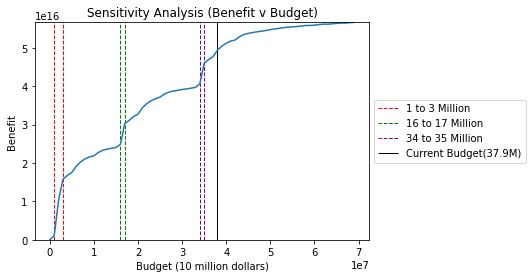

In [62]:
plt.figure() # In this example, all the plots will be in one figure.    
plt.plot(list_objective_x, list_objective_y)
plt.xlabel('Budget (10 million dollars)')
plt.ylabel("Benefit")
plt.title("Sensitivity Analysis (Benefit v Budget)")
ymin, ymax = 0, max(list_objective_y)

plt.vlines(1000000, ymin, ymax,colors='red', ls='--',lw=1, label='1 to 3 Million')
plt.vlines(3000000, ymin, ymax,colors='red', ls='--',lw=1)
plt.vlines(16000000, ymin, ymax,colors='green', ls='--',lw=1, label='16 to 17 Million')
plt.vlines(17000000, ymin, ymax,colors='green', ls='--',lw=1)
plt.vlines(34000000, ymin, ymax,colors='purple', ls='--',lw=1, label='34 to 35 Million')
plt.vlines(35000000, ymin, ymax,colors='purple', ls='--',lw=1)
plt.vlines(37900000, ymin, ymax,colors='black',lw=1, label='Current Budget(37.9M)')
plt.ylim(ymin, ymax+1000000)
plt.legend(loc='center left', bbox_to_anchor=(1., .5))
plt.show()

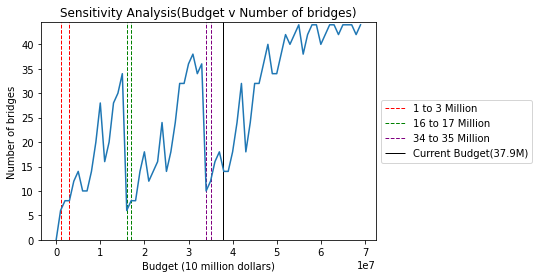

In [63]:
plt.figure() # In this example, all the plots will be in one figure.    
plt.plot(list_objective_x, counter_list)
plt.xlabel('Budget (10 million dollars)')
plt.ylabel("Number of bridges")
plt.title("Sensitivity Analysis(Budget v Number of bridges)")
ymin, ymax = 0, max(counter_list)+0.5
plt.vlines(1000000, ymin, ymax,colors='red', ls='--',lw=1, label='1 to 3 Million')
plt.vlines(3000000, ymin, ymax,colors='red', ls='--',lw=1)
plt.vlines(16000000, ymin, ymax,colors='green', ls='--',lw=1, label='16 to 17 Million')
plt.vlines(17000000, ymin, ymax,colors='green', ls='--',lw=1)
plt.vlines(34000000, ymin, ymax,colors='purple', ls='--',lw=1, label='34 to 35 Million')
plt.vlines(35000000, ymin, ymax,colors='purple', ls='--',lw=1)
plt.vlines(37900000, ymin, ymax,colors='black',lw=1, label='Current Budget(37.9M)')
plt.ylim(ymin, ymax)
plt.legend(loc='center left', bbox_to_anchor=(1., .5))
plt.show()